In [1]:
import numpy as np 
import pandas as pd 

import os

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
label_index = {"dry": 0, "normal":1, "oily":2}
index_label = {0:"dry", 1:"normal", 2:"oily"}

In [10]:
def create_df(base):
    dd = {"images": [], "labels":[]}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)        

In [11]:
train_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train")
test_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test")
valid_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid")

In [14]:
train_df = pd.concat([train_df, valid_df, test_df])
train_df

,images,labels
0,/kaggle/input/oily-dry-and-normal-skin-types-d...,0
1,/kaggle/input/oily-dry-and-normal-skin-types-d...,0
2,/kaggle/input/oily-dry-and-normal-skin-types-d...,0
3,/kaggle/input/oily-dry-and-normal-skin-types-d...,0
4,/kaggle/input/oily-dry-and-normal-skin-types-d...,0
...,...,...
129,/kaggle/input/oily-dry-and-normal-skin-types-d...,2
130,/kaggle/input/oily-dry-and-normal-skin-types-d...,2
131,/kaggle/input/oily-dry-and-normal-skin-types-d...,2
132,/kaggle/input/oily-dry-and-normal-skin-types-d...,2


In [15]:
EPOCHS = 20
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224

In [16]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))
        
        return img, label

In [17]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

In [18]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

In [19]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [20]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [21]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [23]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [24]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()
    
    diff = 0
    total = 0
    acc = 0
    
    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
        
    train_loss += [diff/total]
    train_acc += [acc/total]
    
    model.eval()
    
    diff = 0
    total = 0
    acc = 0
    
    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                
            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
            
    val_loss += [diff/total]
    val_acc += [acc/total]
    
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    scheduler.step()
    
    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epochs 1 train loss 0.046898227984448454 acc 0.4319714399047997 val loss 0.03793488646310473 acc 0.3619047619047619
Epochs 2 train loss 0.027221757710240088 acc 0.6136453788179294 val loss 0.04203436223287431 acc 0.4984126984126984
Epochs 3 train loss 0.020026342895285376 acc 0.7290757635858787 val loss 0.03366554994431753 acc 0.5777777777777777
Epochs 4 train loss 0.013817219046646052 acc 0.8318127727092424 val loss 0.036758095120626784 acc 0.5619047619047619
Epochs 5 train loss 0.009215263821973728 acc 0.8968663228877429 val loss 0.03408997910363334 acc 0.6634920634920635
Epochs 6 train loss 0.007494748834164452 acc 0.9170963903213011 val loss 0.02889892335921999 acc 0.7047619047619048
Epochs 7 train loss 0.005637159228963258 acc 0.938516461721539 val loss 0.02955951898817032 acc 0.7238095238095238
Epochs 8 train loss 0.00350046019154449 acc 0.9646965489884967 val loss 0.027998331236460852 acc 0.746031746031746
Epochs 9 train loss 0.0028234953836540483 acc 0.9726299087663626 val loss

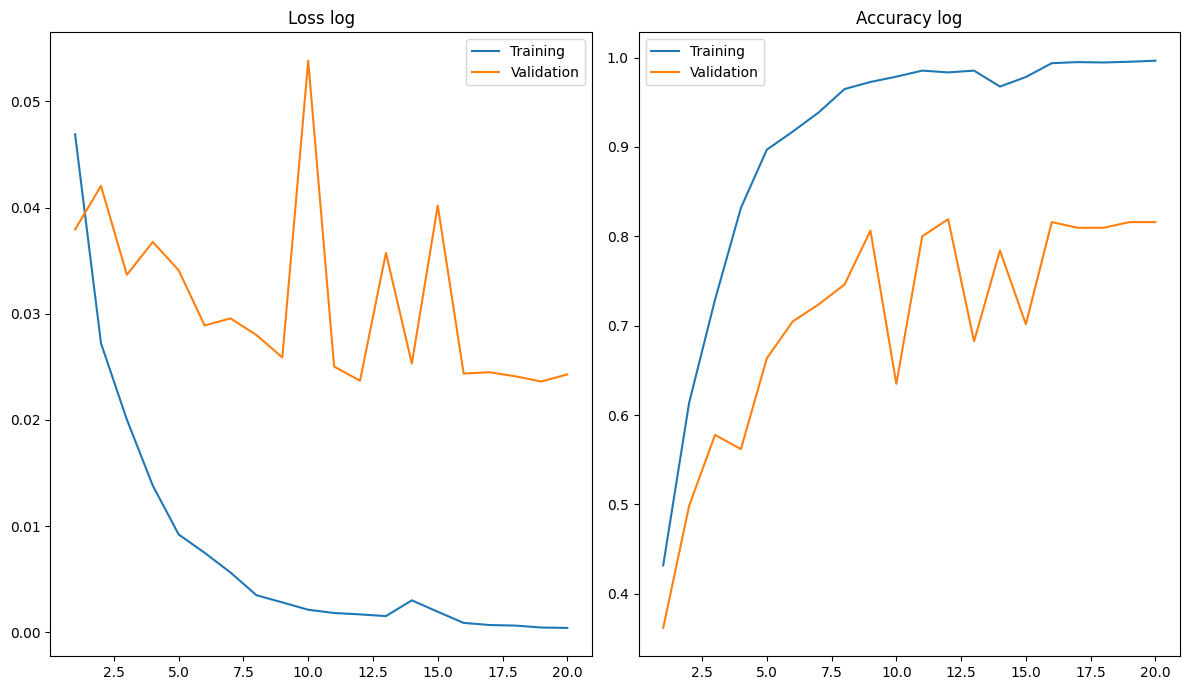

In [25]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [26]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        
        out = best_model(img)
        
        return out.argmax(1).item()

In [42]:
pred = []
actual = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    actual += [test.iloc[i, 1]]

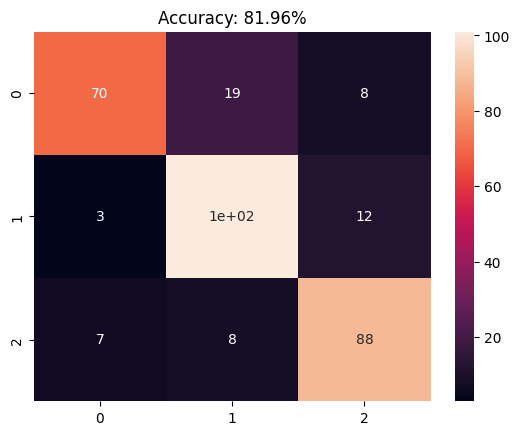

In [43]:
score = accuracy_score(actual, pred)
report = classification_report(actual, pred)
cm = confusion_matrix(actual, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

In [44]:
print(report)

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        97
           1       0.79      0.87      0.83       116
           2       0.81      0.85      0.83       103

    accuracy                           0.82       316
   macro avg       0.83      0.82      0.82       316
weighted avg       0.82      0.82      0.82       316



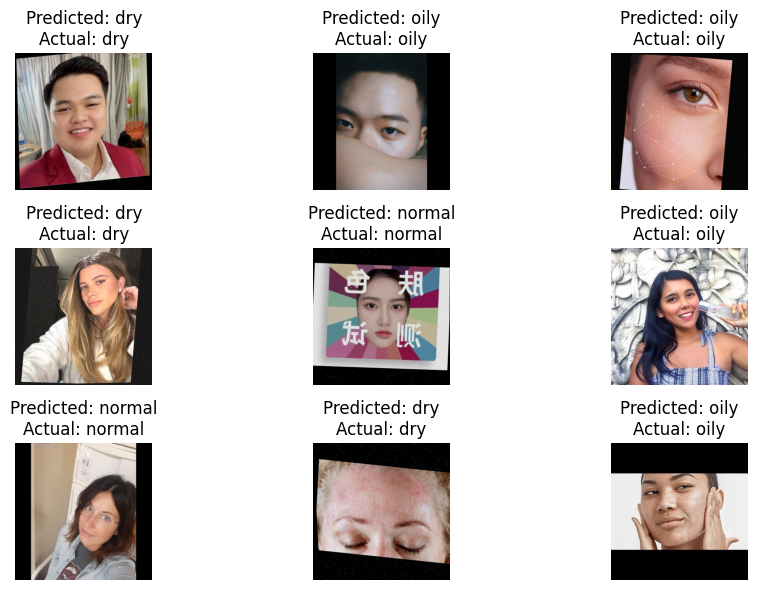

In [49]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))
index = 50
for i in range(3):
    for j in range(3):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nActual: {}".format(index_label[pred[index]], index_label[actual[index]]))
        axes[i][j].axis('off')
        index += 1
        
plt.tight_layout()
plt.show()

In [51]:
torch.save(best_model, '/kaggle/working/model.pt')